In [1]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
from utils import * # Code shared across more than one notebook

# gVirtualXRay CT acquisition vs chest phantom CT data

**Outline:**
This notebook demonstrates the use of gVirtualXRay in a CT medical application. For this experiment, we attempt to recreate a real CT acquisition of the [Lungman chest phantom](https://www.kyotokagaku.com/en/products_data/ph-1_01/) with gVirtualXRay. 

1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
2. Structures in the reference CT have been segmented and labelled. 
3. The resultant surfaces from the segmentations form a virtual lungman model. 
4. We use gVirtualXRay to simulate CT acquisition on this model and 
5. compare the result with the reference CT. 

An advantage of some experiments in this notebook is that a significant number of samples ($512 \times 512 \times 426$) are used in comparisons. A concern is that the quality of the virtual chest phantom, used as the gVirtualXRay sample, is solely dependent on manual segmentation giving additional error to X-Ray data outside of gVirtualXRay's responsibility.  

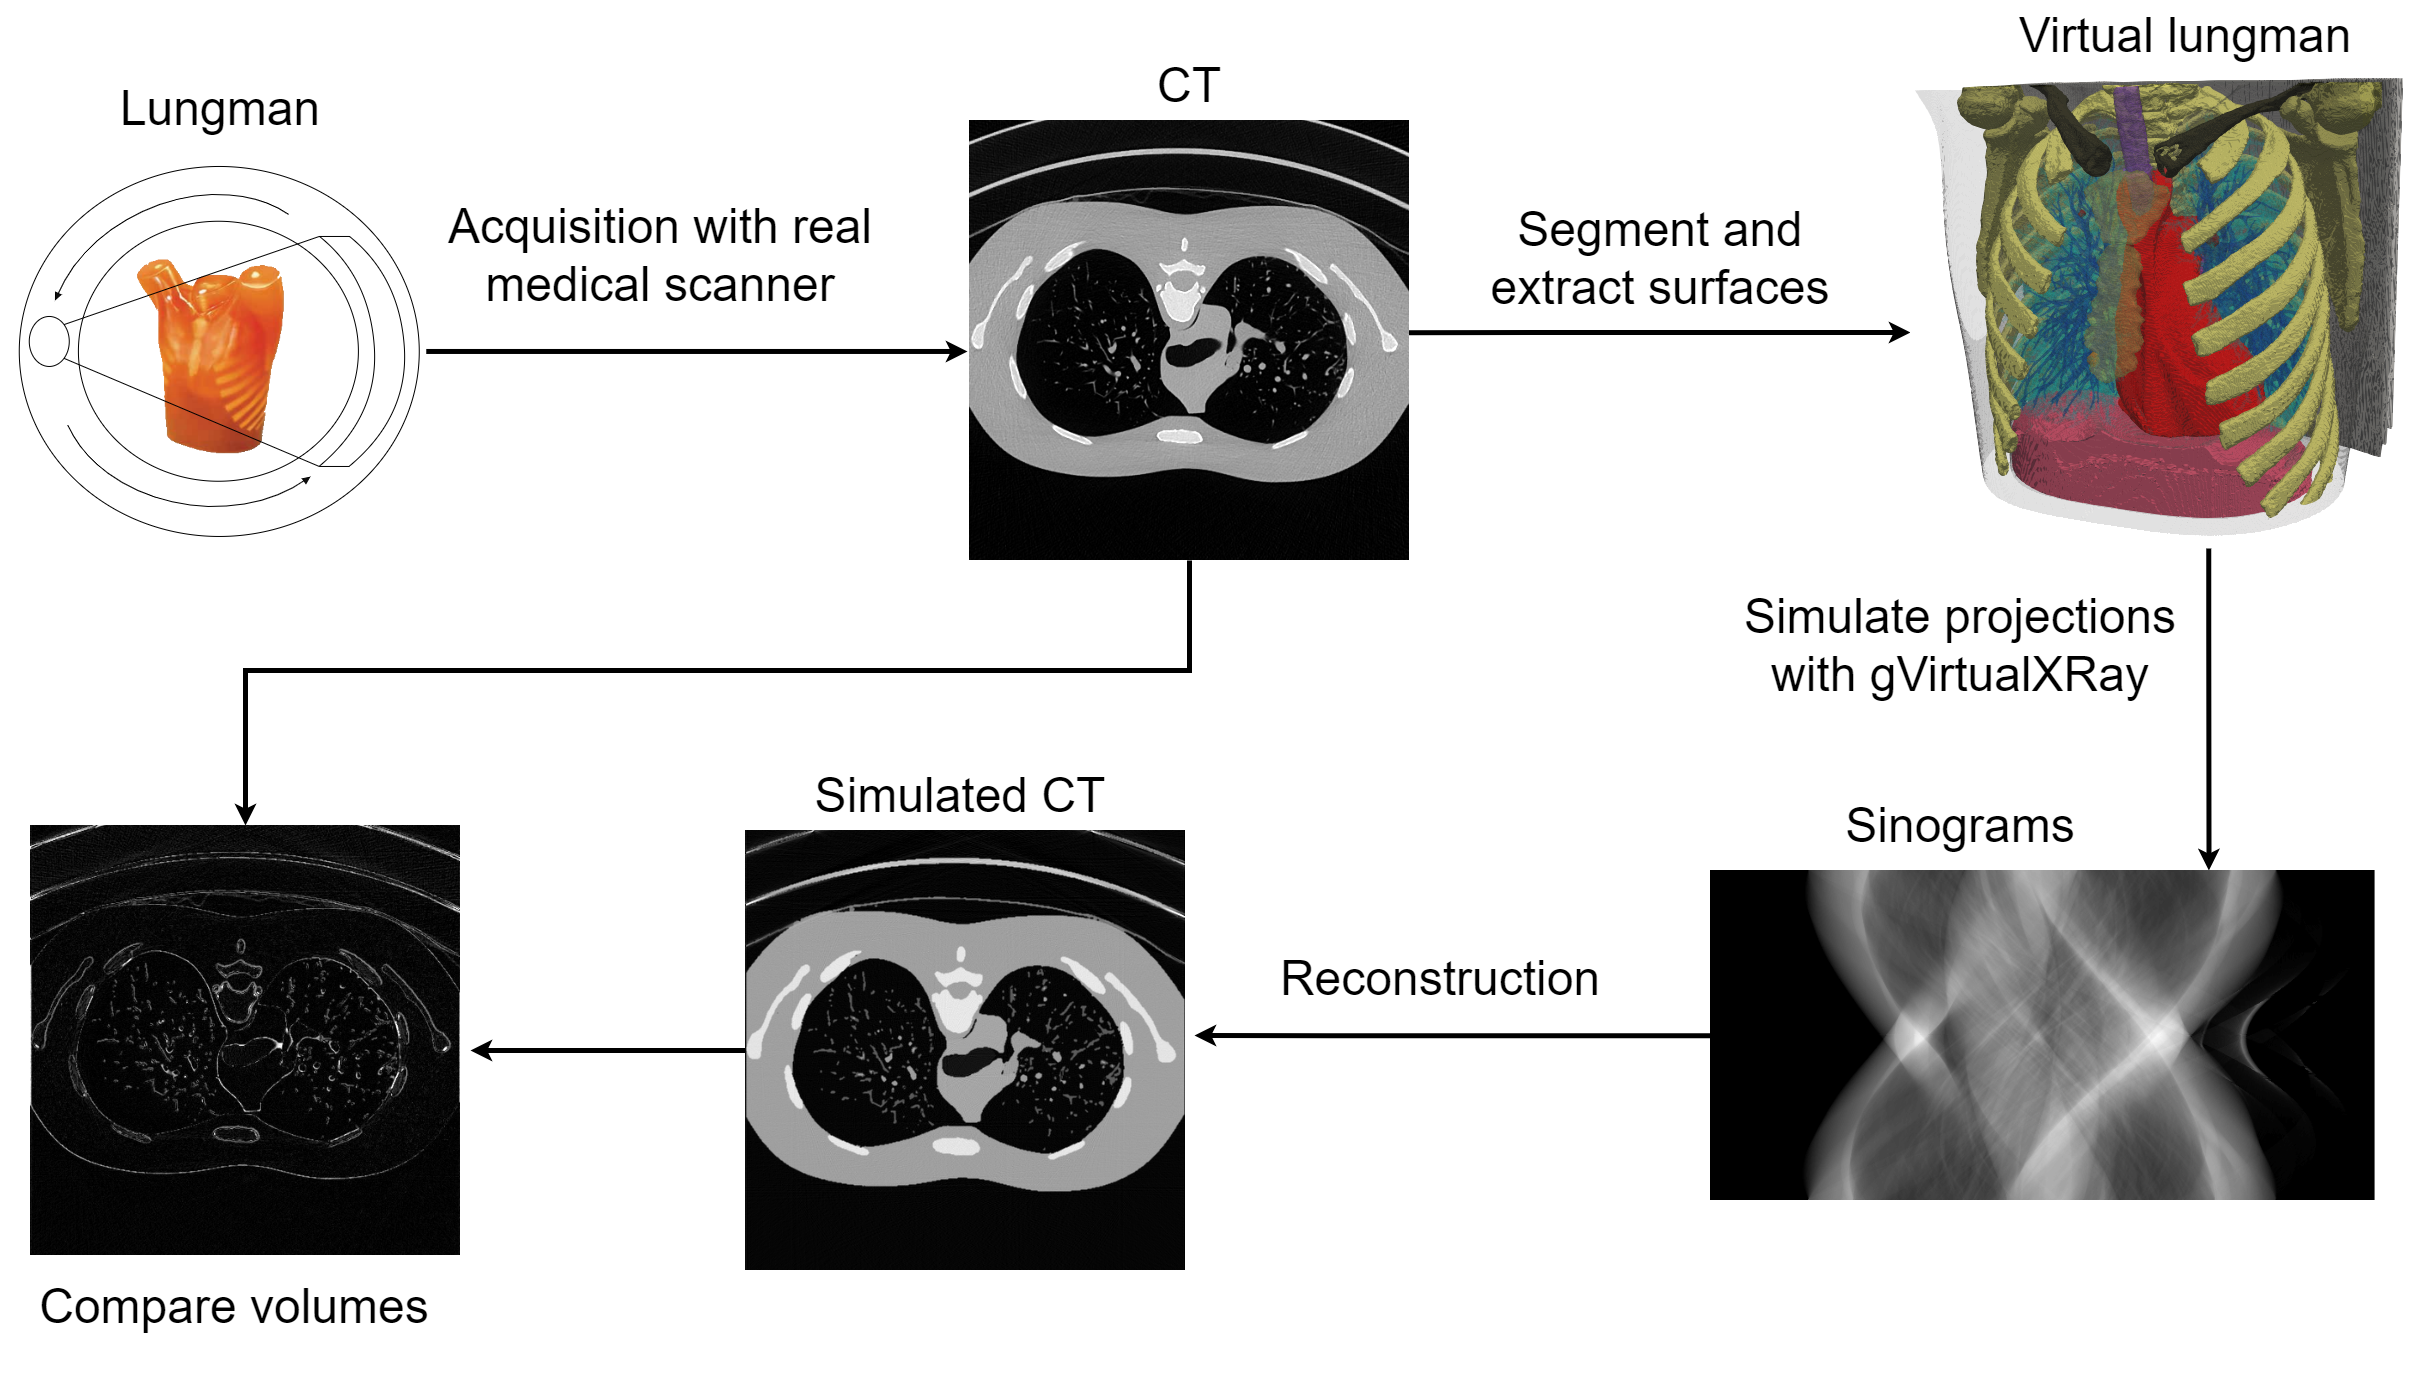

In [2]:
Image("../doc/gvxrflow.drawio.png", width=800)

**Methods and materials:** The setup for gVirtualXRay involved a sample centered about the origin, placing the source 500mm away from the object (SOD) and the detector also 500mm away (SDD). \
The beam is monochromatic with photons having 72keV of energy. A parallel beam is used in this experiment for simplicity because recovering the parameters from the original acquisition with the medical scanner would be difficult. \
The detector is set-up to best match the reference CT accounting for pixel size, resulting in the detector being approximately 453mm wide and 298mm tall. A width of 725 ($512 \times \sqrt{2}$) pixels is used instead of the 512 pixels found in the reference CT so the inscribed circle can be removed during the reconstruction process.

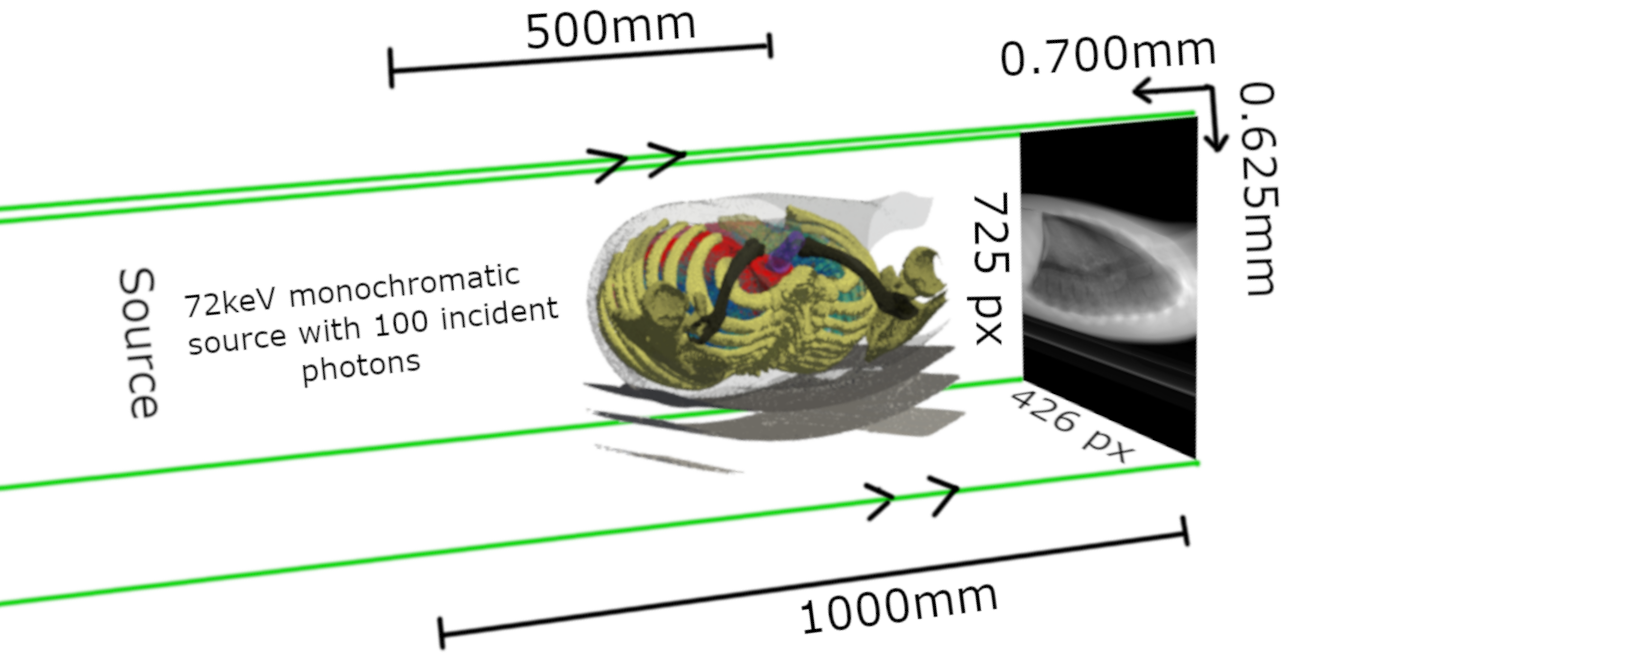

In [3]:
Image("../doc/gvxr-lungman-environment.png", width=800)

In [4]:
#with open('../doc/chest-paraview.gif','rb') as f:
#   display(Image(data=f.read(), format='png', width=480))

# Results

**Diagonal plot comparison**\
These two plots are sampled from the diagonal pixels of slice 150 from both the ground truth CT and simulated CT of the chest phantom.\
<span style="color:green">Green</span>: Ground truth CT plot\
<span style="color:red">Red</span>: Simulated CT plot\
This experiment proves the most significant changes in attenuation are accurately simulated. The simulated CT appears less noisy presumably because our experiment does not account for the natural deviation of image quality that comes with real equipment.

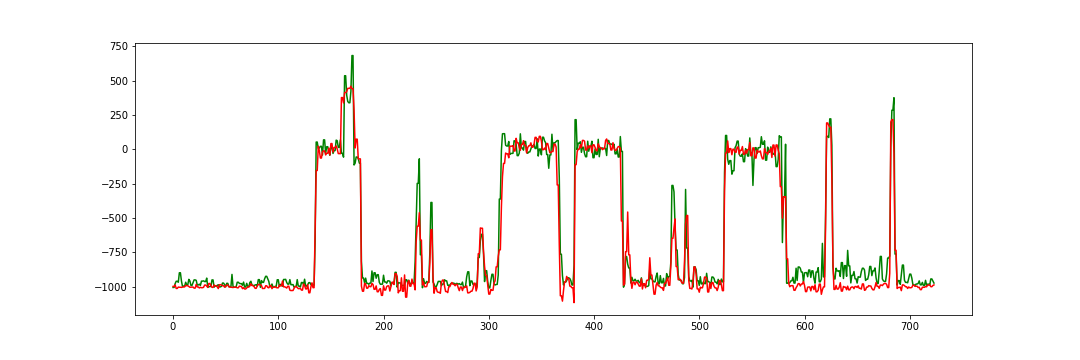

In [5]:
Image("./plots/diagonal-plots-chest-CT.png")

**Quantitative comparisons**\
From qauntative measures we achieved: a ZNCC score of 0.977 (97.7% similarity), a MAPE/MAPD 0.293 and a SSIM score of 0.911. For reference, a good ZNCC and SSIM score is 1 and a good MAPE score is 0.

The calculations were performed on the following platform:

In [6]:
printSystemInfo()

OS:
	Linux 5.3.18-lp152.20.7-default
	x86_64

CPU:
 	Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz

RAM:
	31 GB
GPU:
	Name: NVIDIA GeForce RTX 2080 Ti
	Drivers: 470.42.01
	Video memory: 11 GB


# Import packages

In [7]:
tomography_backend = "scikit-image"
# tomography_backend = "tigre"
# tomography_backend = "tomopy"

In [ ]:
import SimpleITK as sitk
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF file

if tomography_backend == "tomopy":
    import tomopy
elif tomography_backend == "tigre":
    import tigre
    import tigre.algorithms as algs
    import tomopy
elif tomography_backend == "scikit-image":
    from skimage.transform import iradon
    from skimage.transform import radon
else:
    IOError("No tomography reconstruction backend")

from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
#import scipy
import os
import math
import zipfile
import datetime

import imageio

import k3d
import random
import base64
from stl import mesh
from time import sleep

SimpleGVXR 1.0.1 (2021-12-13T16:30:11) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-13T16:30:10) [Compiler: GNU g++] on Linux


# Performance
* The number of threads chosen will largely dictate the speed of reconstruction.
* The number of projections will affect the quality of the reconstruction.
* Artefact filtering, as you can expect, provides better quality image at the expense of speed.
* Artefact filtering on the GPU gives a decent compromise of speed to quality.

In [ ]:
ray_energy = 100
DO_ARTEFACT_FILTERING_ON_GPU = True
DO_ARTEFACT_FILTERING_ON_CPU = False

number_of_projections = 180 #1000;
span = 180
angular_step = span / number_of_projections;
theta_deg = np.linspace(0.0, angular_step * number_of_projections, num=number_of_projections, endpoint=False)

In [ ]:
print("Number of projections:", theta_deg.shape[0])
print("Angle between successive projections:", angular_step)
print("First angle:", theta_deg[0])
print("Last angle:", theta_deg[-1])

# Extract data for this experiment
The labelled volumes are provided compressed in a zip file. Use this procedure to extract the surfaces and masks needed for this notebook.

In [ ]:
# Uncompress the labels
if (False == os.path.isfile("./lungman_data/segmentation-uncompressed/labels.mha")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")

# Read the records for isovalue, average HU
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read labels
rd = vtk.vtkMetaImageReader();
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha";
rd.SetFileName(label_rel_path);
rd.Update()
vtkLabels = rd.GetOutput();

# Create threshold filter
threshold = vtk.vtkImageThreshold();
threshold.SetInputData(vtkLabels);
threshold.SetReplaceOut(0);
threshold.ReplaceOutOn()
threshold.ReplaceInOff();

for i in range(0, len(split_lines)):
    
    tuple_parts = split_lines[i].split('\t');
    
    # See if the surface already exists
    stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
    if (True == os.path.isfile(stl_rel_path)): continue;
    
    # Threshold to get label
    isovalue = int(tuple_parts[0]);
    threshold.ThresholdBetween(isovalue, isovalue);
    threshold.Update();
    vtkIm = threshold.GetOutput();
    
    # Extract surface and save
    vtkSurface = extractSurface(vtkIm, isovalue);
    writeSTL(vtkSurface, stl_rel_path);
    vtkSurface = None;
    vtkIm = None;
    
    

rd = None;


# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [ ]:
json2gvxr.initGVXR("notebook-10.json", "OPENGL");

**Create a parallel photon beam.**

In [ ]:
json2gvxr.initSourceGeometry();
gvxr.setMonoChromatic(ray_energy, "keV", 100);
gvxr.useParallelBeam();

**Create a detector array.**

In [ ]:
json2gvxr.initDetector("notebook-10.json");

**Create a phantom model from each mesh and its material.**

In [ ]:
json2gvxr.initSamples("notebook-10.json", 1);

In [ ]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
print("There are", f"{number_of_triangles:,}", "triangles in total")

## Visualise the virtual patient

In [ ]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    
    fname = sample["Path"]

    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)

    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    if label == "Skin":
        opacity = 0.2
    else:
        opacity = 1
    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity=opacity)

    plot += geometry   

plot.display()
plot.camera = [-331.9588958318764, -378.948200806186, -128.42416661488394, 67.59881627653458, -14.343638117004298, -203.16252140497986, 0.05481655383573701, 0.06127227589210948, 0.9966146966769794]

In [ ]:
fname = 'plots/lungman_model.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(5)
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(5)
    
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

**Visualise a single projection**

In [ ]:
gvxr.computeXRayImage()
gvxr.displayScene()

# Give each mesh an alpha value
alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

# Do projections

Every epoch, the scene is rotated by a step such that the number of chosen projections is reached over 180 degrees and an image is produced on the detector array. At the end a set of X-Ray images is obtained in likeness to the raw data produced by a medical scanner except sliced in a different direction.

In [ ]:
%%capture

gvxr.disableArtefactFiltering()

if DO_ARTEFACT_FILTERING_ON_GPU:
    gvxr.enableArtefactFilteringOnGPU()
elif DO_ARTEFACT_FILTERING_ON_CPU:
    gvxr.enableArtefactFilteringOnCPU()

raw_projections = [];
angles = [];
runtimes = []

# Create a GIF file
writer = None
fname_gif = "plots/lungman_acquisition.gif"

if True: #not os.path.exists(fname_gif):
    writer = imageio.get_writer(fname_gif, mode='I')

# Save the transformation matrix
transformation_matrix_backup = gvxr.getSceneTransformationMatrix()

rotation_axis = json2gvxr.params["Detector"]["UpVector"]

for angle_id in range(0, number_of_projections):

    # Add the rotation angle, starting from 0
    angles.append(angle_id * angular_step)
        
    # Compute an X-ray image
    # xray_image = np.array(gvxr.computeXRayImage());
    start_time = datetime.datetime.now()
    
    xray_image = gvxr.computeXRayImage()
    
    # if xray_image.shape != [208, 1062]:
    #     xray_image = resize(xray_image, [208, 1062])
    
    # xray_image = np.array(gvxr.computeXRayImage());
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)
    
    # Add to the set of projections
    raw_projections.append(xray_image)
    
    # Update the rendering
    gvxr.displayScene();

    # Take a screenshot
    if writer is not None:
        if not angle_id % 30:
            screenshot = gvxr.takeScreenshot()

            plt.figure(figsize= (10,10))
            plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
            plt.imshow(screenshot)
            plt.axis('off')

            plt.tight_layout()

            plt.savefig('temp.png')            
            plt.close()
            
            
            image = imageio.imread("temp.png")
            writer.append_data(image)

    # Rotate the sample
    gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2])
    
# We're done with the writer
if writer is not None:
    writer.close()
    os.remove("temp.png")

# Convert to numpy arrays
raw_projections = np.array(raw_projections)

# Restore the transformation matrix
gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

# Update the rendering
gvxr.displayScene();

In [ ]:
with open('./plots/lungman_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

# Correct flat-field

Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.



In [ ]:
fname = "gVirtualXRay_output_data/lungman_flat.mha"
if not os.path.exists(fname):
    
    corrected_projections = flatFieldCorrection(raw_projections)
    corrected_projections = np.array(corrected_projections).astype(np.single)

    sitk_image = sitk.GetImageFromArray(corrected_projections)
    # sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, fname, useCompression=True)
    
else:
    temp = sitk.ReadImage(fname)
    corrected_projections = sitk.GetArrayFromImage(temp)
    
del raw_projections # Not needed anymore

# Negative log normalisation

In [ ]:
fname = "gVirtualXRay_output_data/lungman_minus_log_projs.mha"

if not os.path.exists(fname):

    minus_log_projs = minusLog(corrected_projections)

    sitk_image = sitk.GetImageFromArray(minus_log_projs)
    # sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
del corrected_projections # Not needed anymore

Display the images

In [ ]:
proj_min = minus_log_projs.min()
proj_max = minus_log_projs.max()

Draw the projection

In [ ]:
ncols = 4
nrows = 2

step = int(minus_log_projs.shape[0] / (ncols * nrows))
slices = range(0, int(minus_log_projs.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(minus_log_projs.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(minus_log_projs[slice_id], cmap='gray', vmin=proj_min, vmax=proj_max)
 
plt.tight_layout()


plt.savefig('plots/digimouse-lungman-projs.pdf')
plt.savefig('plots/digimouse-ground_truth-projs.png')

Draw the sinograms

In [ ]:
fname = "gVirtualXRay_output_data/lungman_sinograms.mha"
    
if not os.path.exists(fname):
    
    sino_shape = [
        minus_log_projs.shape[1],
        minus_log_projs.shape[0],
        minus_log_projs.shape[2]
    ]
    
    sinograms = np.zeros(sino_shape).astype(np.single)
    
    for angle_id in range(minus_log_projs.shape[0]):
        for slice_id in range(minus_log_projs.shape[1]):
            sinograms[slice_id, angle_id] = minus_log_projs[angle_id, slice_id]

    # Drop the first and last slices
    sinograms = sinograms[1:sinograms.shape[0] - 1]
    
    # Save
    sitk_image = sitk.GetImageFromArray(sinograms)
    # sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    sinograms = sitk.GetArrayFromImage(temp)

Plot some sinograms

In [ ]:
ncols = 4
nrows = 2

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id],
                  extent=[0, sinograms.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=proj_min, vmax=proj_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
plt.tight_layout()


plt.savefig('plots/lungman-simulated-sino.pdf')
plt.savefig('plots/lungman-simulated-sino.png')

## Load the ground truth

In [ ]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha");
ground_truth_CT_recons_in_HU = np.array(sitk.GetArrayFromImage(sitk_reader.Execute()));

# Make sure each volume has floating point precision
ground_truth_CT_recons_in_HU = ground_truth_CT_recons_in_HU.astype(np.single);

# Drop the first and last slices
ground_truth_CT_recons_in_HU = ground_truth_CT_recons_in_HU[1:ground_truth_CT_recons_in_HU.shape[0] - 1]

In [ ]:
ncols = 3
nrows = 2

step = int(ground_truth_CT_recons_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(ground_truth_CT_recons_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = ground_truth_CT_recons_in_HU.min()
ct_max_val = ground_truth_CT_recons_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(ground_truth_CT_recons_in_HU.shape[0]))
        ax.imshow(ground_truth_CT_recons_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-ground_truth-CT.pdf')
plt.savefig('plots/lungman-ground_truth-CT.png')

## CT reconstruction of the simulated sinogram

In [ ]:
fname = "gVirtualXRay_output_data/lungman_simu_CT_recons_in_mu.mha"

tomography_backend = "scikit-image"
# tomography_backend = "tigre"
# tomography_backend = "tomopy"

if True:# not os.path.exists(simu_fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        CT_volume_in_mu = recons(sinograms,
                                  theta_deg,  
                                  "parallel",
                                  "hann",
                                  ground_truth_CT_recons_in_HU.shape[2],
                                  ground_truth_CT_recons_in_HU.shape[1],
                                  ground_truth_CT_recons_in_HU.shape[0],
                                  tomography_backend)
    
    # Tomopy or Tigre
    else:
        
        # For TIGRE
        # filter_name = "ram_lak"
        # filter_name = "shepp_logan"
        # filter_name = "cosine"
        # filter_name = "hamming"
        # filter_name = "hann"     
        
        
        # For Tomopy
        # filter_name = "shepp"
        filter_name = "cosine"
        # filter_name = "hann"
        # filter_name = "hamming"
        # filter_name = "ramlak"
        # filter_name = "parzen"
        # filter_name = "butterworth"
        
        CT_volume_in_mu = recons(minus_log_projs,
                                  theta_deg,  
                                  "parallel", 
                                  filter_name, 
                                  ground_truth_CT_recons_in_HU.shape[2], 
                                  ground_truth_CT_recons_in_HU.shape[1], 
                                  ground_truth_CT_recons_in_HU.shape[0], 
                                  tomography_backend) 
        
    sitk_image = sitk.GetImageFromArray(CT_volume_in_mu)
    # sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    # sitk_image.SetOrigin((-pixel_width * CT_volume_in_mu.shape[2] / 2.0,
    #                       -pixel_width * CT_volume_in_mu.shape[1] / 2.0,
    #                       -pixel_height * CT_volume_in_mu.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(simu_fname)
    CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

# del sinograms # Not needed anymore

# Transform to Hounsfield units
The hounsfield unit (HU) is frequently used in radiography as a means to standardise radiodensity. On the hounsfield scale, water has a HU of 0 and air -1000. Each pixel in a radiography image corresponds to the photons linear attenuation coefficient or $\mu$. The transformation for each voxel is as follows.


<center>$HU = 100 \times \frac{\mu - \mu _{water}}{\mu _{water} - \mu _{air}}$</center>

In [ ]:
fname = "gVirtualXRay_output_data/lungman_simu_CT_recons_in_HU.mha"

# The file does not exist
if True:# not os.path.exists(simu_fname):

    MU_air = gvxr.getMuFromHU(-1000.0, ray_energy, "keV")
    MU_water = gvxr.getMuFromHU(0, ray_energy, "keV")

    # MU_air = 0
    # MU_water = gvxr.getMassAttenuationFromCompound("H2O", ray_energy, "keV")
    
    CT_volume_in_HU = 1000.0 * ((CT_volume_in_mu - MU_water) / (MU_water - MU_air))
    CT_volume_in_HU = np.array(CT_volume_in_HU).astype(np.single)        

    sitk_image = sitk.GetImageFromArray(CT_volume_in_HU)
    # sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    # sitk_image.SetOrigin((-pixel_width * CT_volume_in_mu.shape[2] / 2.0,
    #                       -pixel_width * CT_volume_in_mu.shape[1] / 2.0,
    #                       -pixel_height * CT_volume_in_mu.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, fname, useCompression=True)

# The file already exist
else:
    sitk_image = sitk.ReadImage(CT_fname)
    CT_volume_in_HU = sitk.GetArrayFromImage(sitk_image)

# del CT_volume_in_mu # Not needed anymore

In [ ]:
print(MU_air, MU_water)


## Display the CT slices

In [ ]:
ncols = 3
nrows = 2

step = int(CT_volume_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(CT_volume_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(CT_volume_in_HU.shape[0]))
        ax.imshow(CT_volume_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-simulated-CT.pdf')
plt.savefig('plots/lungman-simulated-CT.png')

## Comparison the analytic simulation with the ground truth data

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls. Using the MAPE would lead to large errors for these reasons.

### Ground truth CT reconstruction vs CT reconstructed from simulated projections

In [ ]:
ZNCC_CT = np.mean((ground_truth_CT_recons_in_HU - ground_truth_CT_recons_in_HU.mean()) / ground_truth_CT_recons_in_HU.std() * (CT_volume_in_HU - CT_volume_in_HU.mean()) / CT_volume_in_HU.std())

offset1 = min(ground_truth_CT_recons_in_HU.min(), CT_volume_in_HU.min())
offset2 = 0.01 * (ground_truth_CT_recons_in_HU.max() - ground_truth_CT_recons_in_HU.min())
MAPE_CT = mape(ground_truth_CT_recons_in_HU.flatten() - offset1 + offset2, CT_volume_in_HU.flatten() - offset1 + offset2)
SSIM_CT = [] 

for ref_slice, test_slice in zip(ground_truth_CT_recons_in_HU, CT_volume_in_HU):
    SSIM_CT.append(ssim(ref_slice, test_slice, data_range=ref_slice.max() - ref_slice.min()))

In [ ]:
print("ZNCC CT:", "{0:0.2f}".format(100 * ZNCC_CT) + "%")
print("MAPE CT:", "{0:0.2f}".format(100 * MAPE_CT) + "%")
print("SSIM CT:", "{0:0.2f}".format(np.mean(SSIM_CT)), "+/- {0:0.2f}".format(np.std(SSIM_CT)))

TIGRE:

hann
ZNCC CT: 96.89%
MAPE CT: 40.40%
SSIM CT: 0.30 +/- 0.05

hamming
ZNCC CT: 96.85%
MAPE CT: 40.27%
SSIM CT: 0.28 +/- 0.05

cosine
ZNCC CT: 96.63%
MAPE CT: 38.49%
SSIM CT: 0.23 +/- 0.05

shepp_logan
ZNCC CT: 95.96%
MAPE CT: 32.14%
SSIM CT: 0.15 +/- 0.04

ram_lak
ZNCC CT: 95.40%
MAPE CT: 28.75%
SSIM CT: 0.12 +/- 0.04



Tomopy


parzen
ZNCC CT: 95.80%
MAPE CT: 21.43%
SSIM CT: 0.55 +/- 0.06

cosine
ZNCC CT: 94.77%
MAPE CT: 14.62%
SSIM CT: 0.39 +/- 0.06

hann
ZNCC CT: 94.62%
MAPE CT: 13.23%
SSIM CT: 0.36 +/- 0.05

hamming
ZNCC CT: 94.56%
MAPE CT: 13.15%
SSIM CT: 0.35 +/- 0.05

shepp
ZNCC CT: 93.22%
MAPE CT: 11.53%
SSIM CT: 0.29 +/- 0.05

butterworth
ZNCC CT: 92.41%
MAPE CT: 10.97%
SSIM CT: 0.25 +/- 0.05

ramlak
ZNCC CT: 91.95%
MAPE CT: 10.66%
SSIM CT: 0.24 +/- 0.04



In [ ]:
ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

In [ ]:
ZNCC_slice = np.mean((ref_slice - ref_slice.mean()) / ref_slice.std() * (test_slice - test_slice.mean()) / test_slice.std())

offset1 = min(ref_slice.min(), test_slice.min())
offset2 = 0.01 * (ref_slice.max() - ref_slice.min())
MAPE_slice = mape(ref_slice - offset1 + offset2, test_slice - offset1 + offset2)
SSIM_slice = ssim(ref_slice, test_slice, data_range=ref_slice.max() - ref_slice.min())

print("ZNCC slice:", "{0:0.2f}".format(100 * ZNCC_slice) + "%")
print("MAPE slice:", "{0:0.2f}".format(100 * MAPE_slice) + "%")
print("SSIM slice:", "{0:0.2f}".format(SSIM_slice))

In [ ]:
fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-CT",
                  False,
                 ref_slice.min(), ref_slice.max())

In [ ]:
ref_diag = np.diag(ref_slice)
test_diag = np.diag(test_slice)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="Middle slice of Ground truth")
ax.plot(test_diag, label="Middle slice of volume reconstructed from\nprojections simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

The CT volumes reconstructed from ground truth sinograms and simulated sinograms exhibit the same metrics when compared to the phantom (ZNCC is 99.30% 99.25%, SSIM is 0.66 and 0.63).

In [ ]:
raise IOError("YOU")

# Reconstruct CT

We used ski-kit image's iradon transform to reconstruct each CT slice from sinogram data. Because of how much data is being processed here, the option to use threading (use NUM_RECON_THREADS) was implemented which should speed things up on modern processors. At the end of this routine the CT is finally created.

**Create the reconstruction thread routine**

In [ ]:
def recon(sinograms, CT_to_append_to, theta, iStart, iEnd):
    for i in range(iStart, iEnd):
        data = np.copy(sinograms[i].T);
        slice = iradon(data, theta=theta, circle=False);
        CT_to_append_to[i] = slice;
        format = "reconstructed slice {iSlice}";
        print(format.format(iSlice =i));

**Assign each thread work and create CT**

In [ ]:

num_projections = len(projection_set);
Simulated_CT_in_MU = [None] * num_projections;
handle_recon_threads = [];
iThreadIdx = 0;

# The number of slices each thread will reconstruct
num_slices_per_thread = (int)(num_projections / NUM_RECON_THREADS)

for i in range(0, num_projections):
    
    if i % num_slices_per_thread == 0 and iThreadIdx < NUM_RECON_THREADS:
        
        # The last thread will have to pick up the remaining slices
        if (iThreadIdx == NUM_RECON_THREADS - 1): iEnd = len(projection_set); 
        else:                                     iEnd = i + num_slices_per_thread;
        
        # Set up the thread
        handle_recon_threads.append(Thread(target=recon, 
                                           args=(projection_set, 
                                                 Simulated_CT_in_MU, 
                                                 g_theta, 
                                                 i, iEnd)));
        handle_recon_threads[iThreadIdx].start()
        iThreadIdx+=1;
        format = "Starting thread {iThreadNum}";
        print(format.format(iThreadNum =iThreadIdx));
   

# Wait for the threads to complete
for i in range(len(handle_recon_threads)):
    handle_recon_threads[i].join()
    


In [ ]:
displayLinearPowerScales(Simulated_CT_in_MU[150], "test", "plots/test");
    

# Transform to Hounsfield units
The hounsfield unit (HU) is frequently used in radiography as a means to standardise radiodensity. On the hounsfield scale, water has a HU of 0 and air -1000. Each pixel in a radiography image corresponds to the photons linear attenuation coefficient or $\mu$. The transformation for each voxel is as follows.


<center>$HU = 100 \times \frac{\mu - \mu _{water}}{\mu _{water} - \mu _{air}}$</center>

In [ ]:
MU_air = gvxr.getMuFromHU(-1000.0, ray_energy, "keV");
MU_water = gvxr.getMuFromHU(0, ray_energy, "keV");

Simulated_CT_in_MU = np.array(Simulated_CT_in_MU);

Simulated_CT_in_HU = 1000.0 * ((Simulated_CT_in_MU - MU_water) / (MU_water - MU_air));
displayLinearPowerScales(Simulated_CT_in_HU[150], "test", "plots/test");

Simulated_CT_in_MU = None;

Read the CT volume of the chest phantom acquired using the medical scanner.

In [ ]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha");
Ground_truth_CT = np.array(sitk.GetArrayFromImage(sitk_reader.Execute()));

# Make sure each volume has floating point precision
Ground_truth_CT = Ground_truth_CT.astype(np.single);
Simulated_CT_in_HU = Simulated_CT_in_HU.astype(np.single);

# Visual comparisons

**Checkerboard and absolute difference**\
For the first comparison, the 150th slice of the ground and simulated CT is observed. Each slice is normalised for visual comparisons using the formula.
<center>$f _{i,j} = \frac{f _{i,j} - \bar{f}}{\sigma _{f}}$</center>

In [ ]:
def quickCompare(truth, truth_caption, predict, predict_caption, bDoCheckerboard = False):
    nPlots = 2;
    if (bDoCheckerboard): nPlots = 3;
    
    fig, axes = plt.subplots(1, nPlots);
    
    modeCMap = "gray";
    axes[0].imshow(truth, cmap=modeCMap);
    axes[0].set_title(label=truth_caption);
    axes[1].imshow(predict, cmap=modeCMap);
    axes[1].set_title(label=predict_caption);
    
    if (bDoCheckerboard):
        
        imCheck = compare_images(truth, predict, method='checkerboard', n_tiles=(20,20));
        axes[2].imshow(imCheck, cmap=modeCMap);
        axes[2].set_title(label="Checkerboard comparison");
    
    fig.set_size_inches(20, 20)

In [ ]:
def normImage(image_to_normalise):
    image_to_normalise -= np.mean(image_to_normalise);
    stddev = np.std(image_to_normalise);
    image_to_normalise/= float(stddev);
    #min = np.min(image_to_normalise);
    #max = np.max(image_to_normalise);
    #image_to_normalise -= float(min);
    #image_to_normalise /= float(max -min);

In [ ]:
im2 = Simulated_CT_in_HU[150].astype(np.single);
im1 = Ground_truth_CT[150].astype(np.single);
normImage(im1);
normImage(im2);

In [ ]:
quickCompare(im1, "Ground truth", im2, "Simulated", True);
#fullCompareImages(im1, im2, "test","plots/test", vmax = 5, vmin = -5);

**Diagonal plots**\
It is easier to observe changes in intensity by plotting samples of intensity from compared slices. For the clearest plot, the samples are reduced to being over a diagonal line drawn from the top-left to bottom-right of the image.

In [ ]:
shape = np.shape(Ground_truth_CT);

#Number of samples is equal to the number of pixels on the diagonal
num_plot_samples = math.sqrt((shape[1] ** 2) + (shape[2] ** 2));
num_plot_samples = int(num_plot_samples);


ground_slice = Ground_truth_CT[150];
simulated_slice = Simulated_CT_in_HU[150];
ground_samples = [0] * num_plot_samples;
simulated_samples = [0] * num_plot_samples;
iStep = float(shape[1]) / float(num_plot_samples);
jStep = float(shape[2]) / float(num_plot_samples);
fI = 0.0; fJ = 0.0;
l = 0;
i = 0; j = 0;
while (l < num_plot_samples):
    ground_samples[l] = ground_slice[i][j];
    simulated_samples[l] = simulated_slice[i][j];
    fI += iStep;
    fJ += jStep;
    i = math.floor(fI);
    j = math.floor(fJ);
    l+=1;
    
plt.figure(figsize=(15,5))
plt.plot(ground_samples, 'g');
plt.plot(simulated_samples, 'r');

plt.savefig('plots/comparison-CT-simulations.pdf', bbox_inches='tight')
plt.savefig('plots/comparison-CT-simulations.png')

# Quantifiable comparisons

**ZNCC**\
The zero mean normalised cross-correlation metric is valuable as a measure independant from an image's dynamic range and has the advantage of being able to be presented as a pecentage.

<center>$ZNCC(A,B) = \frac{1}{n(\sigma _{A} \sigma _{B})} \sum_{i = 0}^{n}{(A_{i} - \bar{A})(B_{i} - \bar{B})}$</center>

In [ ]:
def calculateZNCC(ground, predict):
    
    dims = np.shape(ground);
    denom = 1.0;
    i = 0;
    while (i < len(dims)):
        denom *= dims[i];
        i+=1;
        
    if (denom == 0): return 0;
    
    ground_std  = np.std(ground);
    predict_std = np.std(predict);
    denom *= (ground_std * predict_std)
    
    ground_mean = np.mean(ground);
    predict_mean = np.mean(predict);
    
    sum = np.sum(
            (ground  - ground_mean)
            *(predict - predict_mean)
            );
        
    zncc_score = sum / denom;
    return zncc_score

In [ ]:
zncc_score = calculateZNCC(Ground_truth_CT, Simulated_CT_in_HU)
format = "ZNCC score: {score:.3f}%";
print (format.format(score=100*zncc_score));

**MAPE**\
MAPE or MAPD is the second metric in this notebook.   

In [ ]:
def calculateMAPE(ground, predict):
    
    num_voxels = 1;
    dims = np.shape(ground);
    i = 0;
    while (i < len(dims)):
        num_voxels *= dims[i];
        i += 1;
        
    ground_flat = ground.ravel();#ground.flat;#ground.flatten();
    predict_flat =predict.ravel();#predict.flat;# predict.flatten();
    
    acc = 0;
    i = 0;
    while (i < num_voxels):
        ground_val = ground_flat[i];
        if (ground_val == 0): 
            ground_val = 1;
        #if (ground_val != 0):
        acc += abs(ground_val - predict_flat[i]) / ground_val;
        i+= 1;
        
    return acc / num_voxels;

In [ ]:
mape_score = calculateMAPE(Ground_truth_CT, Simulated_CT_in_HU);
format = "MAPE score: {score:.3f}%";
print (format.format(score=100 * mape_score));
print(mape(Ground_truth_CT[50], Simulated_CT_in_HU[50]));

In [ ]:

num_slices = np.shape(Ground_truth_CT)[0];

ground_max = np.max(Ground_truth_CT);
simulated_max = np.max(Simulated_CT_in_HU);
ground_min = np.min(Ground_truth_CT);
simulated_min = np.min(Simulated_CT_in_HU);

max = ground_max if ground_max > simulated_max else simulated_max;
min = ground_min if ground_min < simulated_min else simulated_min;
range =  max - min;
acc = 0;
i = 0;
#High mem when doing whole volume so...
while(i < num_slices):
    acc += ssim(Ground_truth_CT[i], Simulated_CT_in_HU[i], data_range=range);
    i+=1;

ssim_score = acc / num_slices;

format = "SSIM score: {score:.3f}";
print (format.format(score=ssim_score));

In [ ]:
runtimes_mean = round(np.mean(runtimes));
runtimes_std = round(np.std(runtimes));
print(" Lungman - CT acquisition & Real CT of Lungman phantom & " + "{0:0.2f}".format(mape_score) +
      "    &    " +
      "{0:0.2f}".format(zncc_score) + "\\%    &    " +
      "{0:0.2f}".format(ssim_score) + "    &    $" +
      str(Ground_truth_CT.shape[2]) + " \\times " + str(Ground_truth_CT.shape[1]) + " \\times " + str(Ground_truth_CT.shape[0]) + "$    &    " +
      f"{number_of_triangles:,}" + "    &    " + "N/A  &  " +
      "$" + str(runtimes_mean) + " \\pm " + str(runtimes_std) + "$ \\\\")

In [ ]:
# Read the map for isovalue/label to average HU
sitk_meta_reader = sitk.ImageFileReader();
sitk_meta_reader.SetImageIO("MetaImageIO");
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read the labbeled volume
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha" ;#+ tuple_parts[2];
sitk_meta_reader.SetFileName(label_rel_path);
labels = sitk_meta_reader.Execute();

# Create the binary erosion filter
erode = sitk.BinaryErodeImageFilter();

acc_avg_rel_diff = 0;
vec_avg_rel_diff = [];
i = 0;
print("Name\t\tRelative Error\tAbsolute Error");
while ( i < len(split_lines)):
   
    tuple_parts = split_lines[i].split('\t');
    
    name = tuple_parts[2][0:-4];
    kernel_radius = 2;
    
    # Sheets are too slim to be eroded so much
    if (name.find("sheet") != -1):
        kernel_radius = 1;
    
    # Erode the mask
    erode.SetKernelRadius(kernel_radius);
    erode.SetForegroundValue(int(tuple_parts[0]));
    sitk_mask = erode.Execute(labels);
        
    mask = np.array(sitk.GetArrayFromImage(sitk_mask));
    sitk_mask = None
   
    # Apply mask to simulated CT
    simulated_masked = Simulated_CT_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    
    avg_simulated_HU = np.mean(simulated_masked);
    avg_ground_HU = float(tuple_parts[1]);
    avg_rel_diff = (avg_ground_HU - avg_simulated_HU) / avg_ground_HU;
    avg_rel_diff *= 100.0;
    abs_diff =  abs(avg_simulated_HU - avg_ground_HU);
    format = "{structure:<15}\t{rel:<15.3f}\t{abs:.3f}";
    print(format.format(structure=name, rel=avg_rel_diff, abs=abs_diff));
    
    acc_avg_rel_diff += abs(avg_rel_diff);
    vec_avg_rel_diff.append(acc_avg_rel_diff);
    i+=1;
    
avg_rel_diff = acc_avg_rel_diff / len(vec_avg_rel_diff);
print('\n')
format = "Average relative error = {error:.3f}%";
print(format.format(error=avg_rel_diff));